<a id="top"></a>
 <font size="5">tutorial experimenter</font>
> 

> * Prepared by Alfredo López
> * alfredo.lopez@scch.at
> 
<hr>
<hr>

In [1]:
import os
import pitsa
import importlib
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

# Data

<Axes: xlabel='t'>

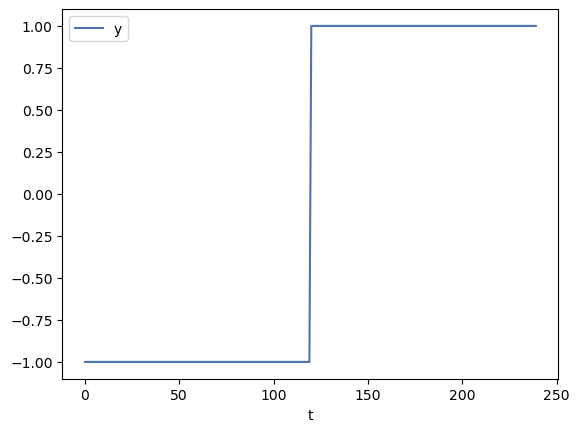

In [5]:
# ramp
n_samples = 240
tast = 120
y = np.concatenate((-np.ones(tast), np.ones(n_samples-tast)))
df = pd.DataFrame(y, columns=['y'])
df.index.name = 't'
df.plot( y='y')

# Sequential BAPC

Lets compute and display $\Delta \theta_s^r$ for a simple univariate model.

In [6]:
# base model
model = DummyRegressor(strategy="mean")
base_model = pitsa.models.regression.SKLearnModel(model=model)

# correction model
model = KNeighborsRegressor(n_neighbors=1) #Set n_neighbors=1 for perfect fit
correction_model = pitsa.models.regression.SKLearnModel(model, name='1NN')
correction_model.ar_order = 0

# meta parameters
n_train = 80 # number of training samples

In [7]:
# bapc for fixed s and fixed window r
time_start = 80
correction_window = 40
parameters, explainers = pitsa.experimenter.run.run_sbapc(df=df,
                                            base_model=base_model, 
                                            correction_model=correction_model, 
                                            n_train=n_train,
                                            time_starts=time_start, 
                                            correction_windows=correction_window)

display(parameters)

,intercept_before,intercept_after,intercept_delta,data,time_start,time_end,correction_window
0,0.0,-0.5,0.5,y,80,159,40


In [8]:
# bapc for fixed s and  all windows r 
time_start = 80
parameters, explainers = pitsa.experimenter.run.run_sbapc(df=df,
                                            base_model=base_model, 
                                            correction_model=correction_model, 
                                            n_train=n_train,
                                            time_starts=time_start)

<Axes: xlabel='time_end', ylabel='intercept_delta'>

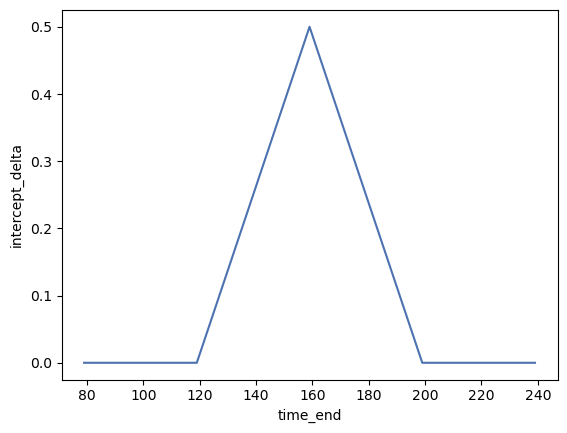

In [9]:
# bapc for all s and and fixed r combinaons
correction_window = 40
parameters, explainers = pitsa.experimenter.run.run_sbapc(df=df,
                                            base_model=base_model, 
                                            correction_model=correction_model, 
                                            n_train=n_train,
                                            correction_windows=correction_window)

sns.lineplot(x='time_end', y='intercept_delta', data=parameters)

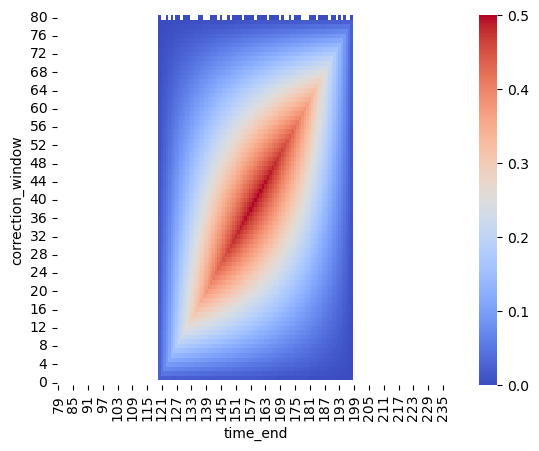

In [10]:
# bapc for all time s and window r combinations
parameters, explainers = pitsa.experimenter.run.run_sbapc(df=df,
                                            base_model=base_model, 
                                            correction_model=correction_model, 
                                            n_train=n_train)

parameters_wide = parameters[['intercept_delta', 'time_end', 'correction_window']].copy()
parameters_wide['time_end'] = parameters_wide['time_end'].astype(int)
parameters_wide['correction_window'] = parameters_wide['correction_window'].astype(int)
parameters_wide = parameters_wide.pivot_table(index='correction_window', columns='time_end', values='intercept_delta')
sns.heatmap(parameters_wide, mask=parameters_wide==0, cmap='coolwarm')
plt.yticks(rotation=0);
plt.gca().invert_yaxis()